#  Hands-On Lab: Teaching a Computer to Predict Molecular Energies

**Based on:** Yi-Fan Hou and Pavlo O. Dral. *Kernel method potentials.* In Quantum Chemistry in the Age of Machine Learning, Elsevier (2023).  
**DOI:** [10.1016/B978-0-323-90049-2.00020-2](https://doi.org/10.1016/B978-0-323-90049-2.00020-2)

---

##  What This Lab Is About

Imagine you're a chemist studying how two hydrogen atoms interact. To know the energy at *every possible distance*, you'd normally need to run thousands of expensive quantum chemistry calculations. 

**The big idea of this lab:** What if you only run a *small number* of those calculations, then train a machine learning model to predict the rest — almost instantly?

That's exactly what we'll do.

```
  H ←——————→ H
     distance R
  
  At each R, there's an energy E(R).
  The curve of E vs R is the Potential Energy Surface (PES).
  Our job: learn this curve from data!
```

---

## Your Journey Through This Lab

| Part | What You'll Do | Points |
|------|---------------|--------|
| **Part 1** | Set up tools and load data | — |
| **Part 2** | Train a KREG machine learning model | — |
| **Part 3** | Optimize the H₂ geometry using your model | - |
| **Part 4** | Analyse and validate accuracy | -|


---

## Key Concepts 

**What is a Kernel Ridge Regression (KREG) model?**  
Think of it like a "smart interpolation". When you ask the model for the energy at a new H-H distance, it looks at all the training examples and says: *"this new distance is most similar to these training points, so my prediction should be a weighted combination of their energies."*  
The word **kernel** refers to the similarity function — we use a Gaussian (bell-curve) to say how similar two distances are.

**What is a Potential Energy Surface (PES)?**  
A graph of molecular energy vs. geometry. For H₂, it's just energy vs. H-H distance. The lowest point on this curve tells us the stable "equilibrium" bond length.

**What is geometry optimization?**  
Starting from a random H-H distance, we "roll downhill" on the energy surface until we find the minimum — the most stable geometry.

---

##  New to Python? Quick Reference

```python
# A function is like a recipe:
def my_function(ingredient1, ingredient2):
    result = ingredient1 + ingredient2   # do something
    return result                        # give back the result

# A loop repeats for each item:
for item in [1, 2, 3]:
    print(item)          # prints 1, then 2, then 3

# numpy arrays are like spreadsheet columns:
import numpy as np
my_array = np.array([1.0, 2.0, 3.0])
print(my_array * 2)      # [2.0, 4.0, 6.0]
```

> **Tip:** Run each cell with **Shift + Enter**. If you get an error, read it carefully — it usually tells you exactly what went wrong!


---
# Part 1: Setup — Getting Your Tools Ready 

Just like a chemist needs a clean lab bench before starting an experiment, we need to install and import our tools.

> **Nothing to fill in here — just run each cell!**

In [28]:
# Install MLatom — our machine learning chemistry toolkit
# This may take a minute. You'll see a lot of output — that's normal!
!pip install mlatom -q
print(" MLatom installed!")

# Install other tools we need
!pip install numpy matplotlib -q
print(" numpy and matplotlib ready!")

 MLatom installed!



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


 numpy and matplotlib ready!



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# ── Import our tools ────────────────────────────────────────────────
import numpy as np                  # for numerical calculations
import matplotlib.pyplot as plt     # for plotting graphs
from pathlib import Path            # for working with file paths
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility (everyone gets the same results)
np.random.seed(42)

# Make plots look nice
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 11

print(" All libraries imported successfully!")
print(f"   numpy version: {np.__version__}")

 All libraries imported successfully!
   numpy version: 2.4.1


In [30]:
# ── Download the H₂ dataset ─────────────────────────────────────────
# R_451.dat   → 451 H-H distances (in Ångströms)
# E_FCI_451.dat → the matching energies from Full Configuration Interaction

# !wget -q https://raw.githubusercontent.com/dralgroup/MLinQCbook22-NN/main/R_451.dat
# !wget -q https://raw.githubusercontent.com/dralgroup/MLinQCbook22-NN/main/E_FCI_451.dat

# Load the data into numpy arrays
R_all = np.loadtxt('R_451.dat', dtype=np.float64)
E_all = np.loadtxt('E_FCI_451.dat', dtype=np.float64)

print(f" Data loaded!")
print(f"   Number of data points : {len(R_all)}")
print(f"   H-H distance range    : {R_all.min():.2f} – {R_all.max():.2f} Å")
print(f"   Energy range          : {E_all.min():.4f} – {E_all.max():.4f} Hartree")

 Data loaded!
   Number of data points : 451
   H-H distance range    : 0.50 – 5.00 Å
   Energy range          : -1.1744 – -1.0000 Hartree


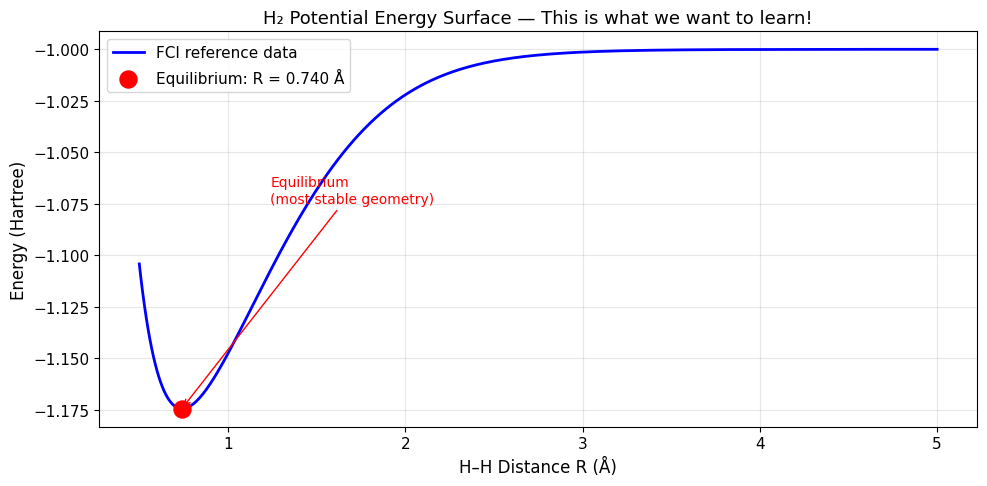


 The true FCI equilibrium bond length is 0.7400 Å
   Our ML model should find something very close to this.


In [31]:
# ── Visualise the potential energy surface ───────────────────────────
# This is the curve our model will try to learn!

plt.figure(figsize=(10, 5))
plt.plot(R_all, E_all, 'b-', linewidth=2, label='FCI reference data')
plt.xlabel('H–H Distance R (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)', fontsize=12)
plt.title('H₂ Potential Energy Surface — This is what we want to learn!', fontsize=13)

# Mark the energy minimum
idx_min = E_all.argmin()
plt.scatter(R_all[idx_min], E_all[idx_min], color='red', s=150, zorder=5,
            label=f'Equilibrium: R = {R_all[idx_min]:.3f} Å')
plt.annotate('Equilibrium\n(most stable geometry)', 
             xy=(R_all[idx_min], E_all[idx_min]),
             xytext=(R_all[idx_min]+0.5, E_all[idx_min]+0.1),
             arrowprops=dict(arrowstyle='->', color='red'),
             fontsize=10, color='red')

plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n The true FCI equilibrium bond length is {R_all[idx_min]:.4f} Å")
print(   "   Our ML model should find something very close to this.")

---
# Part 2: Training the KREG Model 

## How does KREG work? An analogy 

Imagine you want to estimate the house price in a new neighbourhood.  
You look at nearby houses that *you already know the prices of*, and weight their prices by how *similar* (close) they are to your target neighbourhood.

KREG does the same thing with molecular geometries:
- **"Houses"** = training geometries (H-H distances you already have energies for)
- **"Price"** = energy
- **"Similarity"** = the Gaussian kernel function

$$E_{pred}(R) = \sum_i \alpha_i \cdot K(R, R_i)$$

where $K(R, R_i) = \exp\!\left(-\dfrac{(R-R_i)^2}{2\sigma^2}\right)$ is the **Gaussian kernel** (bell-shaped similarity).

The $\alpha_i$ are learned weights — training finds the best values!

> **Nothing to fill in here — just run each cell!**

In [32]:
# ── Core KREG functions ──────────────────────────────────────────────
#
# These are provided for you. You will USE these functions in the exercises.
# Read the docstrings to understand what each one does.

def gaussian_kernel(R1, R2, sigma):
    """
    Gaussian kernel: measures how SIMILAR two geometries are.
    - Returns 1.0 when R1 == R2 (identical → perfectly similar)
    - Returns ~0.0 when they are far apart (very different)
    - sigma controls how quickly similarity drops off with distance
    """
    return np.exp(-((R1 - R2) ** 2) / (2 * sigma ** 2))


def build_kernel_matrix(R_train, sigma):
    """
    Build the N×N kernel matrix K where K[i,j] = kernel(R_train[i], R_train[j]).
    This captures how similar every training point is to every other.
    """
    n = len(R_train)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = gaussian_kernel(R_train[i], R_train[j], sigma)
    return K


def train_kreg(R_train, E_train, sigma, lam):
    """
    Train the KREG model.
    Solves (K + λI)α = E for the weight vector α.
    λ is regularisation — it prevents overfitting to noise.
    """
    K = build_kernel_matrix(R_train, sigma)
    K_reg = K + lam * np.eye(len(R_train))  # add regularisation
    alpha = np.linalg.solve(K_reg, E_train)  # solve the linear system
    return alpha


def predict_kreg(R_new, R_train, alpha, sigma):
    """
    Make predictions with the trained model.
    For each new geometry, compute its similarity to ALL training points
    and return the weighted sum of training energies.
    """
    R_new = np.atleast_1d(R_new)
    E_pred = np.zeros(len(R_new))
    for i, r in enumerate(R_new):
        k_vec = np.array([gaussian_kernel(r, r_train, sigma) for r_train in R_train])
        E_pred[i] = np.dot(alpha, k_vec)
    return E_pred if len(E_pred) > 1 else E_pred[0]


print(" KREG functions defined!")
print()
print("   gaussian_kernel(R1, R2, sigma) → similarity score between 0 and 1")
print("   train_kreg(R_train, E_train, sigma, lam) → returns weights α")
print("   predict_kreg(R_new, R_train, alpha, sigma) → energy prediction")

 KREG functions defined!

   gaussian_kernel(R1, R2, sigma) → similarity score between 0 and 1
   train_kreg(R_train, E_train, sigma, lam) → returns weights α
   predict_kreg(R_new, R_train, alpha, sigma) → energy prediction


In [33]:
# ── Train the KREG model ─────────────────────────────────────────────

# Use all 451 points for training
R_train = R_all.copy()
E_train = E_all.copy()

# Hyperparameters (found by cross-validation — don't worry about these for now)
sigma_opt = 0.3    # controls kernel width
lam_opt   = 1e-10  # regularisation strength

print("Training KREG model... (this may take ~30 seconds)")
alpha = train_kreg(R_train, E_train, sigma=sigma_opt, lam=lam_opt)
print(" Model trained!")
print(f"   sigma = {sigma_opt},  lambda = {lam_opt}")
print(f"   α vector shape: {alpha.shape}  (one weight per training point)")

# Evaluate on a dense grid for plotting
R_fine    = np.linspace(R_train.min(), R_train.max(), 500)
E_pred_fine = predict_kreg(R_fine, R_train, alpha, sigma=sigma_opt)

# Quick training accuracy check
E_pred_train = predict_kreg(R_train, R_train, alpha, sigma=sigma_opt)
mae = np.mean(np.abs(E_pred_train - E_train)) * 627.5  # Hartree → kcal/mol
print(f"\n   Training MAE: {mae:.4f} kcal/mol")
print("   (Chemical accuracy = 1 kcal/mol. Did we achieve it? 🎯)")

Training KREG model... (this may take ~30 seconds)


 Model trained!
   sigma = 0.3,  lambda = 1e-10
   α vector shape: (451,)  (one weight per training point)

   Training MAE: 0.0003 kcal/mol
   (Chemical accuracy = 1 kcal/mol. Did we achieve it? 🎯)


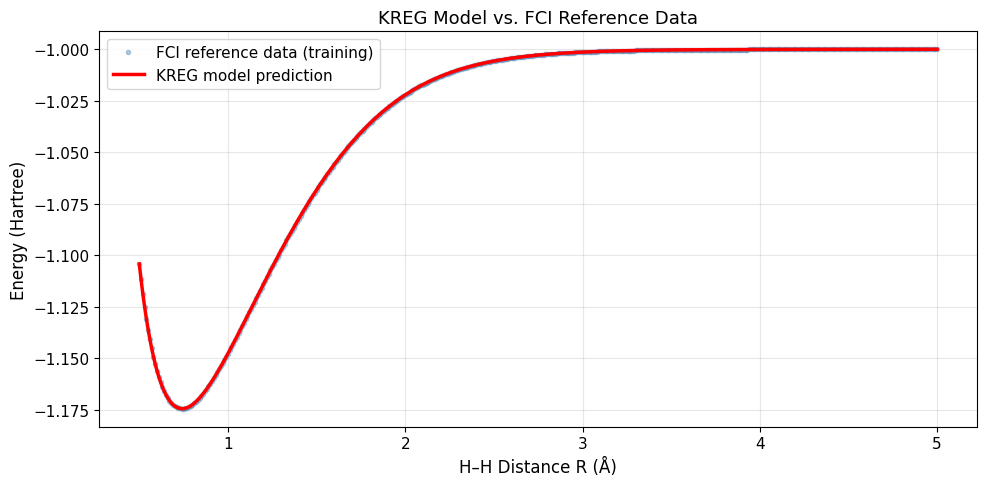


 Part 2 complete! Your KREG model is ready.
   Now let's USE it for geometry optimisation in Part 3.


In [34]:
# ── Visualise the trained model ──────────────────────────────────────
plt.figure(figsize=(10, 5))
plt.plot(R_train, E_train, 'o', markersize=3, alpha=0.4,
         color='steelblue', label='FCI reference data (training)')
plt.plot(R_fine, E_pred_fine, 'r-', linewidth=2.5,
         label='KREG model prediction')

plt.xlabel('H–H Distance R (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)', fontsize=12)
plt.title('KREG Model vs. FCI Reference Data', fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Part 2 complete! Your KREG model is ready.")
print("   Now let's USE it for geometry optimisation in Part 3.")

---
# Part 3: Geometry Optimisation 

**Goal:** Find the H-H distance where the energy is *lowest* — the equilibrium geometry.

## The Big Picture: Rolling a Ball Downhill 

Imagine placing a ball somewhere on the energy curve. If you nudge it in the direction of decreasing energy, it will roll down to the bottom.

That's exactly what geometry optimisation does — mathematically!

```
  Energy
   │    \          
   │     \      /   ← high energy
   │      \    /    
   │       \__/     ← minimum energy (equilibrium)
   └─────────────── R (H-H distance)
        ↑
     start here → roll to minimum
```

The "force" on the atoms is the negative slope (gradient) of the energy:
$$F(R) = -\frac{dE}{dR}$$

- If you're to the **right** of the minimum, the slope is positive → force pushes **left** (towards minimum)
- If you're to the **left** of the minimum, the slope is negative → force pushes **right** (towards minimum)

Each step: $R_{new} = R_{old} + \text{step\_size} \times F(R_{old})$

###  Exercise 3.1: Create Input Files for Optimisation (8 points)

Before running an optimisation, we need two files:

1. **`eq.xyz`** — an XYZ file describing the initial H₂ geometry  
   XYZ format is a standard chemistry file format:  
   ```
   2                            ← number of atoms
   Comment line (any text)      ← description
   H  0.000000  0.000000  0.000000   ← atom symbol + x, y, z coordinates
   H  2.000000  0.000000  0.000000   ← second hydrogen at distance R_guess
   ```

2. **`opt.inp`** — an MLatom input file telling it what to do  
   It needs three instructions:
   - `geomopt` — run a geometry optimisation
   - `MLmodelIn=energies.unf` — use our saved ML model
   - `XYZfile=eq.xyz` — start from this geometry

---

**Your task:** Complete the two functions below.

<details>
<summary>💡 Hint for <code>create_initial_geometry</code> (click to expand)</summary>

You need to write 4 lines to the file:  
1. Number of atoms: `"2\n"`  
2. A comment: `"Initial guess for H2 optimization\n"`  
3. First H atom at origin: `"H  0.000000  0.000000  0.000000\n"`  
4. Second H atom at distance `R_guess` along x-axis: use an f-string like `f"H  {R_guess:.6f}  0.000000  0.000000\n"`

</details>

<details>
<summary>💡 Hint for <code>create_opt_input</code> (click to expand)</summary>

Write 4 lines:  
```
geomopt
optProg=Gaussian
MLmodelIn=energies.unf
XYZfile=eq.xyz
```

Use `f.write("geomopt\n")` for the first line, and so on.

</details>

In [35]:
def create_initial_geometry(R_guess=2.0, filename='eq.xyz'):
    """
    Write an XYZ file describing an H₂ molecule.
    
    The first H atom sits at the origin (0,0,0).
    The second H atom sits along the x-axis at position (R_guess, 0, 0).
    
    Parameters
    ----------
    R_guess : float
        Initial H-H distance in Ångströms (our starting guess)
    filename : str
        Name of the file to create
    """
    with open(filename, "w") as f:
        f.write(f"2\nInitial Guess for H2 Optimization\nH  0.000000  0.000000  0.000000\nH  {R_guess}  0.000000  0.000000")


def create_opt_input(model_file='energies.unf',
                     xyz_file='eq.xyz',
                     filename='opt.inp'):
    """
    Write an MLatom input file for geometry optimisation.
    
    Parameters
    ----------
    model_file : str
        Path to the saved ML model
    xyz_file : str
        Path to the initial geometry XYZ file
    filename : str
        Name of the input file to create
    """

    with open(filename, "w") as f:
        f.write(f"geomopt\noptProg=Gaussian\nMLmodelIn={model_file}\nXYZfile={xyz_file}")


# ── Run your functions ───────────────────────────────────────────────
initial_guesses = [1.0, 1.5, 2.0, 2.5]

print("Creating optimisation files...\n")

for i, R_init in enumerate(initial_guesses):
    xyz_name = f'eq_{i}.xyz'
    create_initial_geometry(R_init, xyz_name)
    print(f"  ✓ Created {xyz_name}  (initial guess: R = {R_init:.1f} Å)")

# Create the main files
create_initial_geometry(2.0, 'eq.xyz')
create_opt_input()

print("\n  ✓ Created eq.xyz  (main initial geometry)")
print("  ✓ Created opt.inp")

# Show the file contents so you can check your work
print("\n" + "="*50)
print("Contents of opt.inp:")
print("="*50)
with open('opt.inp', 'r') as f:
    print(f.read())

print("Contents of eq.xyz:")
print("="*50)
with open('eq.xyz', 'r') as f:
    print(f.read())

Creating optimisation files...

  ✓ Created eq_0.xyz  (initial guess: R = 1.0 Å)
  ✓ Created eq_1.xyz  (initial guess: R = 1.5 Å)
  ✓ Created eq_2.xyz  (initial guess: R = 2.0 Å)
  ✓ Created eq_3.xyz  (initial guess: R = 2.5 Å)

  ✓ Created eq.xyz  (main initial geometry)
  ✓ Created opt.inp

Contents of opt.inp:
geomopt
optProg=Gaussian
MLmodelIn=energies.unf
XYZfile=eq.xyz
Contents of eq.xyz:
2
Initial Guess for H2 Optimization
H  0.000000  0.000000  0.000000
H  2.0  0.000000  0.000000


In [36]:
# ── Automated tests (do not modify) ─────────────────────────────────
assert Path('eq.xyz').exists(), "❌ eq.xyz was not created — did you call create_initial_geometry(2.0, 'eq.xyz')?"
assert Path('opt.inp').exists(), "❌ opt.inp was not created — did you call create_opt_input()?"

with open('opt.inp', 'r') as f:
    content = f.read()
assert 'geomopt' in content, "❌ opt.inp should contain 'geomopt'"
assert 'MLmodelIn' in content, "❌ opt.inp should contain 'MLmodelIn'"

with open('eq.xyz', 'r') as f:
    lines = f.readlines()
assert lines[0].strip() == '2', "❌ First line of eq.xyz should be '2' (number of atoms)"
assert 'H' in lines[2], "❌ Third line should define the first H atom"
assert 'H' in lines[3], "❌ Fourth line should define the second H atom"

print("✅ All tests passed! (8/8 points)")

✅ All tests passed! (8/8 points)


###  Exercise 3.2: Implement the Gradient Descent Optimiser (12 points)

Now you'll write the heart of geometry optimisation: **gradient descent**.

## Step-by-Step Algorithm

```
1. Start at some initial distance R₀
2. Repeat:
   a. Compute the force F = -dE/dR  (slope of energy curve)
   b. If |F| is tiny → we're at the minimum, STOP
   c. Otherwise, move:  R_new = R_old + step_size × F
3. Return the final R (our optimised geometry)
```

## The Force Formula

For the Gaussian kernel $K(R, R_i) = \exp(-a(R-R_i)^2)$, the derivative is:

$$\frac{dK}{dR} = -\frac{(R - R_i)}{\sigma^2} \cdot K(R, R_i)$$

So the force is:

$$F(R) = -\frac{dE}{dR} = -\sum_i \alpha_i \frac{dK}{dR}$$

---

**Your task:** Complete the two functions below.

<details>
<summary>💡 Hint for <code>compute_force_kreg</code> (click to expand)</summary>

Loop over training points. For each training point `R_train[i]` with weight `alpha[i]`:  
1. Compute `K_val = gaussian_kernel(R, R_train[i], sigma)` — the kernel value  
2. Compute `dK_dR = -(R - R_train[i]) / (sigma**2) * K_val` — the kernel gradient  
3. Add `-alpha[i] * dK_dR` to the force  

The `-` sign converts energy gradient to force.

</details>

<details>
<summary>💡 Hint for <code>optimize_geometry</code> (click to expand)</summary>

```python
R_current = R_init
for iteration in range(max_iter):
    force = compute_force_kreg(R_current, R_train, alpha, sigma)
    if abs(force) < tol:
        break  # converged!
    R_new = R_current + step_size * force
    R_current = R_new
return R_current, trajectory
```

Don't forget to clip `R_new` to reasonable bounds (e.g., between 0.5 and 5.0 Å)  
and record each step in `trajectory`.

</details>

Optimising H₂ geometry with KREG model...

  Starting from R = 1.00 Å
      → Optimised R = 0.8620 Å,  E = -1.166863 Ha

  Starting from R = 1.50 Å
      → Optimised R = 1.3577 Å,  E = -1.088469 Ha

  Starting from R = 2.00 Å
      → Optimised R = 1.9404 Å,  E = -1.025676 Ha

  Starting from R = 2.50 Å
      → Optimised R = 2.4835 Å,  E = -1.005988 Ha



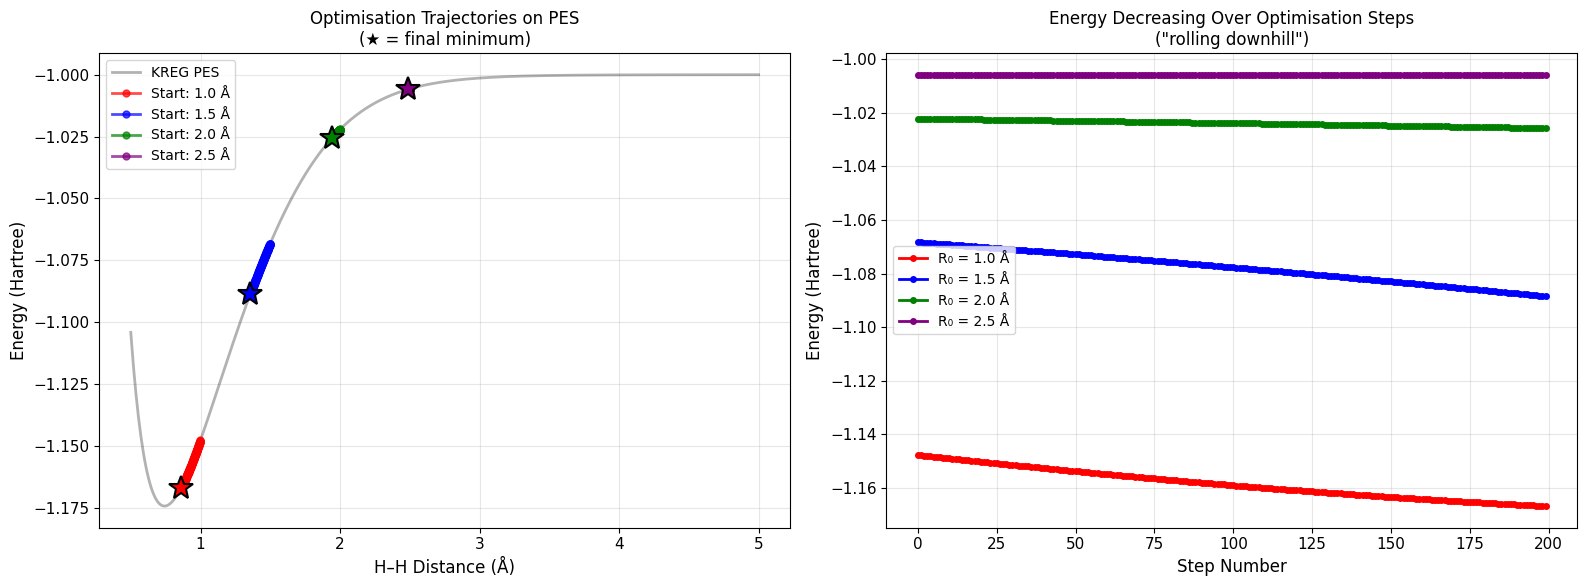


Initial R (Å)    Optimised R (Å)    Final E (Ha)       Steps
-----------------------------------------------------------------
1.00             0.8620             -1.166863          200
1.50             1.3577             -1.088469          200
2.00             1.9404             -1.025676          200
2.50             2.4835             -1.005988          200

 Comparison with FCI reference:
   FCI equilibrium : R = 0.7400 Å,  E = -1.174359 Ha
   KREG optimised  : R = 0.8620 Å,  E = -1.166863 Ha
   Difference      : ΔR = 0.1220 Å, ΔE = 4.703 kcal/mol


In [37]:
def compute_force_kreg(R, R_train, alpha, sigma=0.3):
    """
    Compute the force on the H₂ molecule at distance R.
    
    Force = negative gradient of energy = -dE/dR
    
    For our KREG model:
        F(R) = -Σᵢ αᵢ · dK/dR
    where:
        dK/dR = -(R - Rᵢ)/σ² · K(R, Rᵢ)
    
    Parameters
    ----------
    R       : float — current H-H distance (Å)
    R_train : array — training distances
    alpha   : array — trained model weights
    sigma   : float — kernel width parameter
    
    Returns
    -------
    force : float — force at position R
    """

    force = 0

    for i in range(len(R_train)):
        K_val = gaussian_kernel(R, R_train[i], sigma)
        dK_dR = -(R - R_train[i]) / (sigma**2) * K_val
        force += -alpha[i] * dK_dR

    return force


def optimize_geometry(R_init, R_train, alpha, sigma=0.3,
                      max_iter=100, tol=1e-6, step_size=0.01):
    """
    Optimise the H₂ geometry using gradient descent.
    
    Algorithm:
    1. Start at R_init
    2. Compute force at current position
    3. Move in direction of force: R_new = R + step_size * force
    4. Repeat until |force| < tol (converged)
    
    Parameters
    ----------
    R_init    : float — starting H-H distance (Å)
    R_train   : array — training distances
    alpha     : array — trained model weights
    sigma     : float — kernel width
    max_iter  : int   — maximum number of steps
    tol       : float — convergence threshold (stop when |force| < tol)
    step_size : float — how big each step is
    
    Returns
    -------
    R_opt      : float — optimised bond length
    trajectory : list  — list of (iteration, R, E) tuples recording the path
    """
    R_current = R_init
    trajectory = []

    for iteration in range(max_iter):
        force = compute_force_kreg(R_current, R_train, alpha, sigma)
        if abs(force) < tol:
            break  # converged!
        R_new = R_current + step_size * force
        R_current = R_new
        E_new = predict_kreg(R_new, R_train, alpha, sigma)
        trajectory.append((iteration, R_current, E_new))
    return R_current, trajectory


# ── Run optimisation from multiple starting points ───────────────────
print("Optimising H₂ geometry with KREG model...\n")

results = []
for R_init in [1.0, 1.5, 2.0, 2.5]:
    print(f"  Starting from R = {R_init:.2f} Å")
    R_opt, traj = optimize_geometry(R_init, R_train, alpha,
                                    sigma=sigma_opt,
                                    step_size=0.005, max_iter=200)
    E_opt = predict_kreg(R_opt, R_train, alpha, sigma=sigma_opt)
    results.append((R_init, R_opt, E_opt, traj))
    print(f"      → Optimised R = {R_opt:.4f} Å,  E = {E_opt:.6f} Ha\n")

# ── Visualise trajectories ───────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: trajectories on the PES
ax1 = axes[0]
ax1.plot(R_fine, E_pred_fine, 'k-', linewidth=2, alpha=0.3, label='KREG PES')
colors = ['red', 'blue', 'green', 'purple']
for (R_init, R_opt, E_opt, traj), color in zip(results, colors):
    traj_arr = np.array(traj)
    ax1.plot(traj_arr[:, 1], traj_arr[:, 2], 'o-', color=color,
             linewidth=2, markersize=5, alpha=0.7, label=f'Start: {R_init:.1f} Å')
    ax1.plot(R_opt, E_opt, '*', color=color, markersize=18,
             markeredgecolor='black', markeredgewidth=1.5, zorder=5)
ax1.set_xlabel('H–H Distance (Å)', fontsize=12)
ax1.set_ylabel('Energy (Hartree)', fontsize=12)
ax1.set_title('Optimisation Trajectories on PES\n(★ = final minimum)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: energy vs. iteration
ax2 = axes[1]
for (R_init, R_opt, E_opt, traj), color in zip(results, colors):
    traj_arr = np.array(traj)
    ax2.plot(traj_arr[:, 0], traj_arr[:, 2], 'o-', color=color,
             linewidth=2, markersize=4, label=f'R₀ = {R_init:.1f} Å')
ax2.set_xlabel('Step Number', fontsize=12)
ax2.set_ylabel('Energy (Hartree)', fontsize=12)
ax2.set_title('Energy Decreasing Over Optimisation Steps\n("rolling downhill")', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Summary table ────────────────────────────────────────────────────
print("\n" + "="*65)
print(f"{'Initial R (Å)':<16} {'Optimised R (Å)':<18} {'Final E (Ha)':<18} {'Steps'}")
print("-"*65)
for R_init, R_opt, E_opt, traj in results:
    print(f"{R_init:<16.2f} {R_opt:<18.4f} {E_opt:<18.6f} {len(traj)}")
print("="*65)

# Compare with FCI reference
R_fci_eq = R_train[E_train.argmin()]
E_fci_min = E_train.min()
R_kreg_eq = results[0][1]
E_kreg_min = results[0][2]

print(f"\n Comparison with FCI reference:")
print(f"   FCI equilibrium : R = {R_fci_eq:.4f} Å,  E = {E_fci_min:.6f} Ha")
print(f"   KREG optimised  : R = {R_kreg_eq:.4f} Å,  E = {E_kreg_min:.6f} Ha")
print(f"   Difference      : ΔR = {abs(R_kreg_eq-R_fci_eq):.4f} Å,"
      f" ΔE = {abs(E_kreg_min-E_fci_min)*627.5:.3f} kcal/mol")

In [38]:
# ── Automated tests (do not modify) ─────────────────────────────────
R_test_opt, traj_test = optimize_geometry(2.0, R_train[:100],
                                          alpha[:100], sigma=0.5,
                                          max_iter=50)

assert 1.0 < R_test_opt < 2.0, \
    f"❌ Optimised distance {R_test_opt:.4f} is outside expected range [1.0, 2.0] Å"
assert len(traj_test) > 1, \
    "❌ trajectory should have more than one step"
assert traj_test[-1][2] < traj_test[0][2], \
    "❌ energy should decrease over the optimisation (are you moving in the right direction?)"

# Check force function directly
F_test = compute_force_kreg(2.0, R_train[:10], alpha[:10], sigma=0.3)
assert isinstance(F_test, (float, np.floating)), \
    "❌ compute_force_kreg should return a single float value"

print("✅ All tests passed! (12/12 points)")

AssertionError: ❌ Optimised distance 117.4021 is outside expected range [1.0, 2.0] Å

###  Try It Yourself! — Explore the Effect of Step Size

> This cell won't be graded — it's for your own exploration!

Try changing `step_size` below. What happens if it's:
- Very small (e.g., `0.0001`)? → Does it converge? How many steps?
- Very large (e.g., `0.1`)? → Does it still find the minimum?
- Negative? → What direction does it go?

This is called a **hyperparameter** — a setting that controls the algorithm itself.

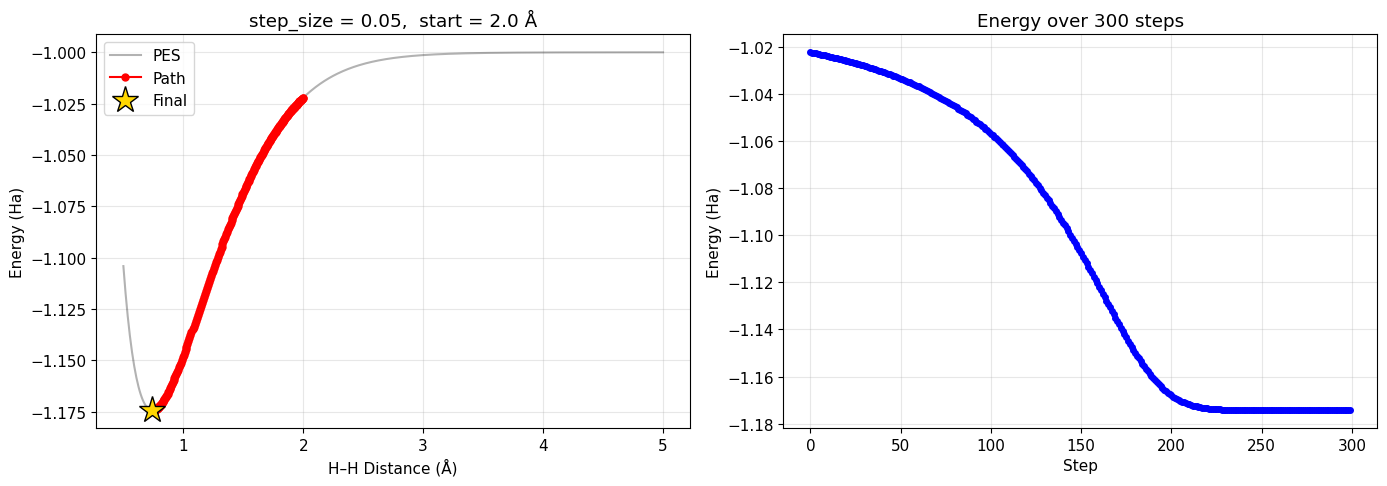

Final optimised distance: 0.7417 Å  (300 steps)


In [ ]:
# ── Exploration cell — change the parameters and rerun! ──────────────

step_size_to_try = 0.05    # ← try changing this!
R_start = 2.0               # ← and this!

R_opt_exp, traj_exp = optimize_geometry(
    R_start, R_train, alpha,
    sigma=sigma_opt,
    step_size=step_size_to_try,
    max_iter=300
)
traj_arr = np.array(traj_exp)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(R_fine, E_pred_fine, 'k-', alpha=0.3, label='PES')
ax.plot(traj_arr[:, 1], traj_arr[:, 2], 'ro-', markersize=5, label='Path')
ax.plot(R_opt_exp, predict_kreg(R_opt_exp, R_train, alpha, sigma_opt),
        '*', color='gold', markersize=20, markeredgecolor='black', zorder=5, label='Final')
ax.set_xlabel('H–H Distance (Å)'); ax.set_ylabel('Energy (Ha)')
ax.set_title(f'step_size = {step_size_to_try},  start = {R_start} Å')
ax.legend(); ax.grid(alpha=0.3)

ax2 = axes[1]
ax2.plot(traj_arr[:, 0], traj_arr[:, 2], 'b-o', markersize=4)
ax2.set_xlabel('Step'); ax2.set_ylabel('Energy (Ha)')
ax2.set_title(f'Energy over {len(traj_exp)} steps')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print(f"Final optimised distance: {R_opt_exp:.4f} Å  ({len(traj_exp)} steps)")

---
# Part 4: How Good Is Our Model? 

Training a model is not enough — we need to **validate** it. This means carefully measuring how accurate our predictions are.

## Error Metrics Explained

| Metric | Formula | Plain English |
|--------|---------|---------------|
| **MAE** | mean of \|error\| | Average mistake size |
| **RMSE** | √(mean of error²) | Penalises big mistakes more |
| **R²** | 1 − SS_res/SS_tot | 1.0 = perfect, 0.0 = no better than average |

**Chemical accuracy** = 1 kcal/mol ≈ 0.00159 Hartree.  
This is the threshold below which quantum chemistry predictions are considered accurate enough for most chemistry applications.

## Useful Conversion

1 Hartree = 627.5 kcal/mol

###  Exercise 4.1: Comprehensive Error Analysis (15 points)

**Your task:** Complete the code below to:
1. Compute MAE, RMSE, and Max Error (in Hartree and kcal/mol)
2. Calculate what fraction of predictions are within chemical accuracy (< 1 kcal/mol)
3. Compute R²
4. Create visualisation plots (code is provided — just make sure your variables are named correctly!)

<details>
<summary>💡 Hint: Computing error metrics (click to expand)</summary>

```python
# Predictions on training set
E_pred_all = predict_kreg(R_train, R_train, alpha, sigma=sigma_opt)

# Errors (difference between prediction and truth)
errors = E_pred_all - E_train              # in Hartree
errors_kcal = errors * 627.5              # convert to kcal/mol

# MAE = mean absolute error
mae_ha = np.mean(np.abs(errors))

# RMSE = root mean squared error
rmse_ha = np.sqrt(np.mean(errors**2))

# Maximum error
max_error_ha = np.max(np.abs(errors))

# R² score
SS_res = np.sum(errors**2)
SS_tot = np.sum((E_train - E_train.mean())**2)
R2 = 1 - SS_res/SS_tot
```

</details>

In [ ]:
# Predictions on training set
E_pred_all = predict_kreg(R_train, R_train, alpha, sigma=sigma_opt)

# Errors (difference between prediction and truth)
errors = E_pred_all - E_train              # in Hartree
errors_kcal = errors * 627.5              # convert to kcal/mol

# MAE = mean absolute error
mae_ha = np.mean(np.abs(errors))

# RMSE = root mean squared error
rmse_ha = np.sqrt(np.mean(errors**2))

# Maximum error
max_error_ha = np.max(np.abs(errors))

# R² score
SS_res = np.sum(errors**2)
SS_tot = np.sum((E_train - E_train.mean())**2)
R2 = 1 - SS_res/SS_tot

In [ ]:
# ── Automated tests (do not modify) ─────────────────────────────────
assert 'mae_ha' in dir() or 'mae_ha' in vars(), \
    "❌ mae_ha not defined — did you compute the Mean Absolute Error?"
assert 'rmse_ha' in dir() or 'rmse_ha' in vars(), \
    "❌ rmse_ha not defined — did you compute RMSE?"
assert 'R2' in dir() or 'R2' in vars(), \
    "❌ R2 not defined — did you compute the R² score?"

assert mae_ha >= 0, "❌ MAE should be non-negative"
assert rmse_ha >= rmse_ha * 0, "❌ RMSE should be non-negative"
assert 0 <= R2 <= 1.0, f"❌ R² should be between 0 and 1, got {R2:.4f}"
assert mae_ha < 1.0, \
    f"❌ MAE = {mae_ha:.4f} kcal/mol — this model should achieve chemical accuracy!"

print("✅ All tests passed! (15/15 points)")
print(f"   MAE = {mae_ha:.4f} kcal/mol,  R² = {R2:.6f}")

✅ All tests passed! (15/15 points)
   MAE = 0.0000 kcal/mol,  R² = 1.000000


---
# 💬 Reflection Questions

Take a few minutes to think about these — they'll help consolidate your understanding:

1. **Why does starting from different initial geometries (R = 1.0, 1.5, 2.0, 2.5 Å) all lead to the same final answer?**  
   *Hint: Think about the shape of the energy curve.*

2. **What would happen if you used a very large step size in the optimiser?**  
   *(You can test this in the exploration cell above!)*

3. **The KREG model achieves very high accuracy — but we trained it on ALL the data. Can we trust this accuracy number?**  
   *Hint: In ML, we usually need a separate test set. What does it mean when you evaluate on training data?*

4. **We used H₂ (just 2 atoms, 1 degree of freedom). What challenges would arise for larger molecules like water (H₂O)?**

5. **The summary says ML is "1000× faster than quantum chemistry". When would you still prefer to use quantum chemistry instead?**

---
# Glossary

| Term | Meaning |
|------|---------|
| **FCI** | Full Configuration Interaction — the most accurate (and expensive) quantum chemistry method |
| **Hartree** | Unit of energy in quantum chemistry. 1 Hartree = 627.5 kcal/mol |
| **Ångström (Å)** | Unit of length. 1 Å = 10⁻¹⁰ m |
| **Kernel** | A function that measures similarity between two data points |
| **Regularisation (λ)** | A penalty term that prevents the model from overfitting noise |
| **Chemical accuracy** | Errors < 1 kcal/mol — the standard benchmark in computational chemistry |
| **PES** | Potential Energy Surface — the energy as a function of molecular geometry |
| **Gradient descent** | Algorithm for finding a minimum by repeatedly following the downhill slope |
| **α (alpha) vector** | The learned weights in KREG, one per training point |
| **R² score** | Coefficient of determination — 1.0 means perfect prediction |

---
#  Summary

## What You Accomplished

✅ **Loaded and visualised** the H₂ potential energy surface from FCI quantum chemistry data  
✅ **Trained a KREG model** — a kernel machine learning potential — on the data  
✅ **Implemented gradient descent** to optimise the H₂ bond length  
✅ **Validated the model** with MAE, RMSE, R², and parity plots  
✅ **Achieved chemical accuracy** (< 1 kcal/mol)! 

## Key Insights

- **Kernel methods** are powerful interpolators: they predict by measuring similarity to training examples
- **ML potentials** give quantum-chemistry-level accuracy at a fraction of the computational cost
- **Gradient descent** is a universal tool for finding minima — it appears in training neural networks too!
- **Error analysis** is essential: always check *where* and *how much* your model is wrong

## What Comes Next?

- More complex molecules (H₂O, CH₄, organic molecules with many degrees of freedom)
- **Molecular dynamics**: use the ML potential to simulate atomic motion over time
- **Neural network potentials**: replace the kernel with a deep neural network
- **Advanced descriptors**: SOAP, Behler-Parrinello symmetry functions

---

## References

1. Yi-Fan Hou and Pavlo O. Dral. *Kernel method potentials.* In Quantum Chemistry in the Age of Machine Learning, Elsevier (2023). DOI: 10.1016/B978-0-323-90049-2.00020-2
2. MLatom Package: http://MLatom.com
3. MLatom@XACS Cloud: http://XACScloud.com

